# Iris Flower Dataset

This document presents intepretation method for the Iris Flower Dataset (see https://en.wikipedia.org/wiki/Iris_flower_data_set). The interpretation is produced using LIME and our aproches.



In [1]:
import sys
sys.path.append('../..')

import numpy as np
from sklearn import datasets
import sklearn.ensemble
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

import lime.lime_tabular
from density_lime.lime_tabular import DensityLimeTabularExplainer
from sklearn.linear_model import HuberRegressor as Linear

# Data spiral

In [2]:
data = datasets.load_iris()
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data.data, data.target, train_size=0.80)

# Training a RF Model

In [3]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
y_all_pred = rf.predict(data.data)

In [4]:
print('Random Forest MSError: ', np.mean((y_test_pred - y_test) ** 2))
print('MSError when predicting the mean: ', np.mean((y_train.mean() - y_test) ** 2))

Random Forest MSError:  0.03333333333333333
MSError when predicting the mean:  0.700625


# Interpretation and Explanation

In [5]:
from density_lime.explanations.visualization import GridPlot

In [6]:
i = 3
x_explain = x_test[i]
x_explain = np.array([6.0, 3., 5, 1.5])
y_explain = 1
x_explain,y_explain, rf.predict(x_explain.reshape(1, -1))

(array([6. , 3. , 5. , 1.5]), 1, array([1]))

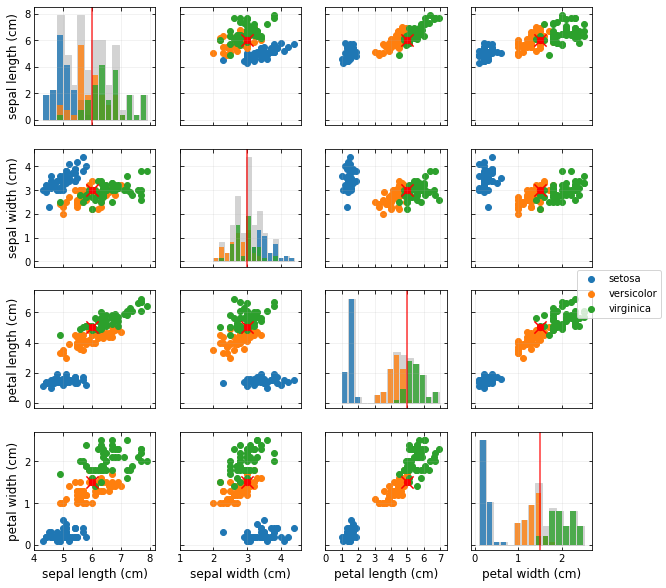

In [7]:
# Code to plot the data and the instance that we want to explain.
x = data.data
y = y_all_pred
y_names = {i:name for i, name in enumerate(data.target_names)}
axis, _ = GridPlot.plot(x=x, x_cols_name=data.feature_names, y=y, y_names=y_names)
GridPlot.plot_instance(x_explain, axis)
for ax in axis.ravel():
    start, end = ax.get_xlim()
    stepsize = 1
    ax.xaxis.set_ticks(np.arange(int(start), end, stepsize))

Form the above figure, we can see that the feature **pental length (cm)** can perfectly separate the class setosa from the other two. Additionally, for values of **pental length (cm)**  between 2.5 and ~5, the predicted class is versicolor, and we would expect that increase the value **pental length (cm)** close to 5 will increase the probability of the ML predict the class virginica. A similar behavior can be observed for the feature **pental width (cm)**.

## Lime Standard Explantion

In [8]:
categorical_features = []

In [9]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=data.feature_names, class_names=data.target_names, categorical_features=categorical_features, verbose=True, mode='classification')

In [10]:
exp = explainer.explain_instance(x_explain, rf.predict_proba, num_features=4, model_regressor=Linear())

Intercept 0.27553209563912257
Prediction_local [0.70235918]
Right: 0.51


In [11]:
exp.show_in_notebook(show_table=True)

## Lime KDE Explantion

In [32]:
explainer_mani = DensityLimeTabularExplainer(x_train, sample_around_instance=True, manifold='kde', feature_names=data.feature_names, class_names=data.target_names, categorical_features=categorical_features, verbose=True, mode='classification')

Best Parameter for the KDE:
{'bandwidth': 0.22777777777777777}
Score: -74.42580324339784


In [33]:
exp_mani = explainer_mani.explain_instance_manifold(
    x_explain, rf.predict_proba, num_features=4, n_min_kernels=20, model_regressor=Linear())

Intercept 3.4665205823702867
Prediction_local [0.57662939]
Right: 0.51


In [34]:
exp_mani.show_in_notebook(show_table=True)

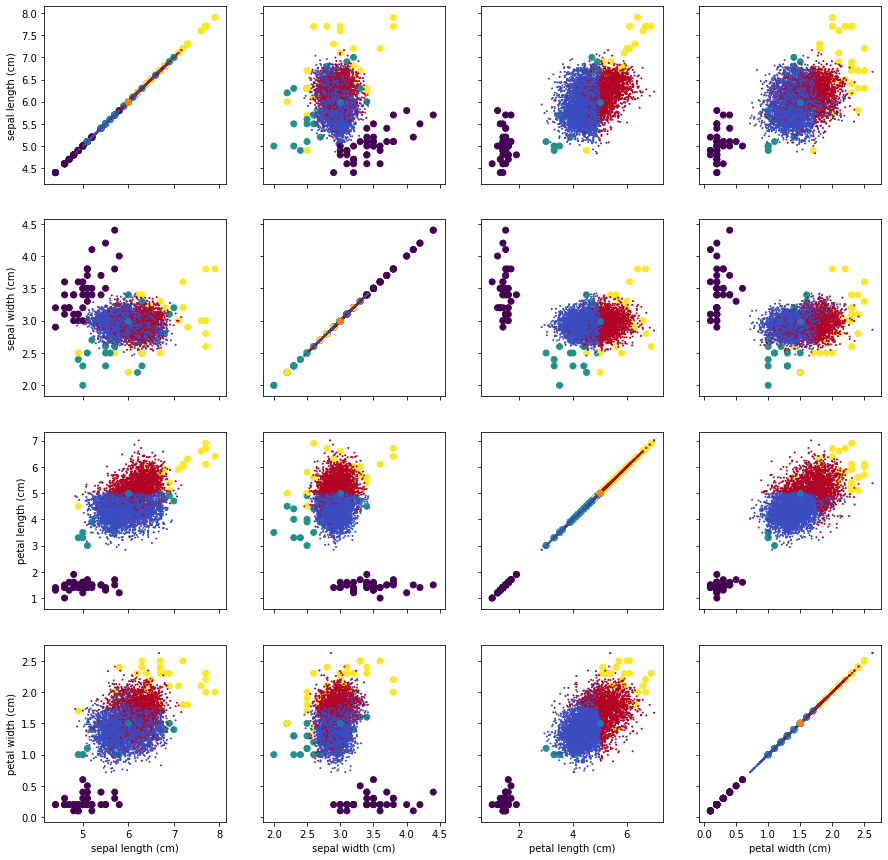

In [35]:
ax, cp = explainer_mani.plot(x_train, figsize=(15, 15), y=y_train_pred)
explainer_mani.plot_samples(ax, model=rf, cmap='coolwarm')
explainer_mani.plot(x_explain.reshape(1, -1), ax)
plt.show()

## Lime KDE-PCA Explantion

# TODO: use the accumulated varience to select the n_components of the PCA

In [36]:
explainer_mani = DensityLimeTabularExplainer(
    x_train, sample_around_instance=True, manifold='kde-pca'
    , feature_names=data.feature_names, class_names=data.target_names
    , categorical_features=categorical_features
    , verbose=True, mode='classification')

Best Parameter for the KDE:
{'bandwidth': 0.2822222222222222}
Score: -66.51244505363528


In [41]:
exp_mani = explainer_mani.explain_instance_manifold(
    x_explain, rf.predict_proba, num_features=4, n_min_kernels=20, num_samples=5000)

Intercept 3.1795257504779393
Prediction_local [0.58370296]
Right: 0.51


/home/tiago/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.37425e-18): result may not be accurate.
  overwrite_a=True).T


In [42]:
exp_mani.show_in_notebook(show_table=True)

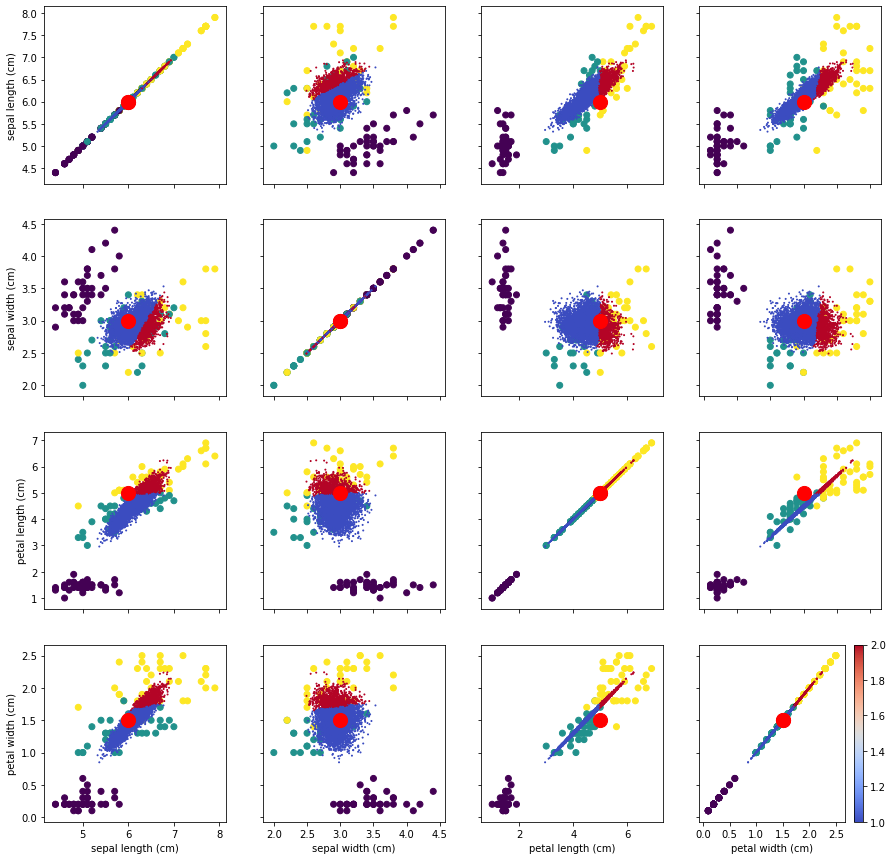

In [43]:
ax, cp = explainer_mani.plot(x_train,  figsize=(15, 15), y=y_train_pred)
ax, cp = explainer_mani.plot_samples(ax, model=rf, cmap='coolwarm')
explainer_mani.plot(x_explain.reshape(1, -1), ax, s=200, y='red')
plt.colorbar(cp)
plt.show()

In [44]:
explainer_mani.manifold.sample()

array([[5.89210537, 7.47916877, 0.92712044, 0.39116906]])

## Lime KDE-Kernel-PCA Explantion

In [47]:
explainer_mani = DensityLimeTabularExplainer(x_train, sample_around_instance=True, manifold='kde-kpca', feature_names=data.feature_names, class_names=data.target_names, categorical_features=categorical_features, verbose=True, mode='classification')

Best Parameter for the KDE:
{'bandwidth': 0.01}
Score: 65.18538158616907


In [48]:
exp_mani = explainer_mani.explain_instance_manifold(
    x_explain, rf.predict_proba, num_features=4, n_min_kernels=20
    , model_regressor=Linear())

Intercept 0.7366082568635665
Prediction_local [0.50999997]
Right: 0.51


/home/tiago/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.3009e-17): result may not be accurate.
  overwrite_a=True).T


In [49]:
exp_mani.show_in_notebook(show_table=True)

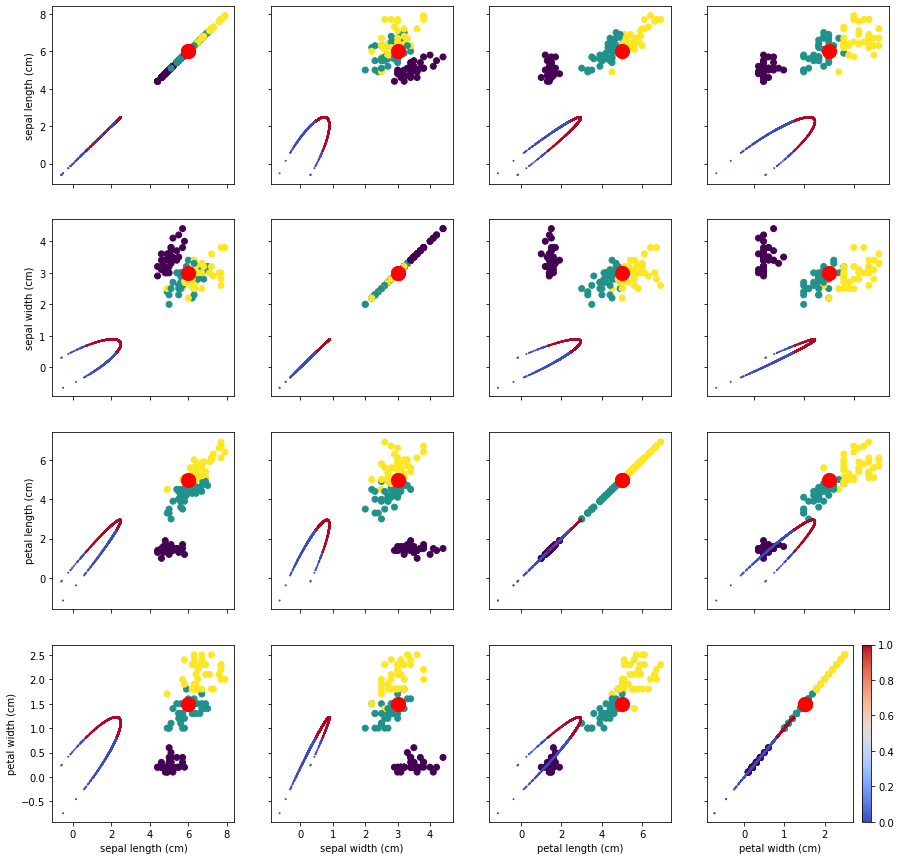

In [50]:
ax, cp = explainer_mani.plot(x_train,  figsize=(15, 15), y=y_train_pred)
ax, cp = explainer_mani.plot_samples(ax, model=rf, cmap='coolwarm')
explainer_mani.plot(x_explain.reshape(1, -1), ax, s=200, y='red')
plt.colorbar(cp)
plt.show()